<center>
<h1> Wilson The Cryptohamster </h1>
<h2>Trading Cryptocurrency with the Power of a cute Syrian Hamster</h2>
<hr>
<h1>Exploratory Data Analysis</h1>
<hr>
</center>

In this Notebook, we explore the raw data created from the hamster wheel sensor. The goals are as follows:

1. Determine the parameters used for the decision process (e.g., timeout between two wheel runs, speed, distance).
2. Find out how much Wilson travels on a usual night.

# Install dependencies

In [1]:
#%pip install pandas numpy matplotlib seaborn pymysql

# Import libraries and constants

We also set the default dpi of figures a bit higher and tell pandas to ignore some warnings (setting with copy).

In [23]:
import matplotlib
import os
import pandas as pd
import pymysql
import seaborn as sns
import sys

# Add path to source files
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from src.python.utils import load_credentials

# Constants
from src.python.constants import (
    DATABASE,
    HOST_REMOTE,
    PORT,
    TABLE_HAMSTERWHEEL,
)

matplotlib.rcParams['figure.dpi'] = 200
pd.options.mode.chained_assignment = None


# Connect to the MySQL Database

The database is running on the RPi.

In [24]:
# Load credentials to connect to the database
FULL_PATH_TO_CREDENTIALS = './../credentials.cred'
user, password = load_credentials(filepath=FULL_PATH_TO_CREDENTIALS)

# Create mysql connection
mysql_connection = pymysql.connect(
    host=HOST_REMOTE,
    user=user,
    password=password,
    db=DATABASE,
    port=PORT,
    charset='utf8'
)


# Check data in the hamsterwheel table

The `hamsterhweel` table contains all the measurements where the magnetic sensor triggered a close. The absence of a record in the database means that the sensor was open. 

In [25]:
query = f"SELECT * FROM {TABLE_HAMSTERWHEEL}"
df = pd.read_sql(
    sql=query,
    con=mysql_connection,
    index_col='hamsterwheel_id'
)

/Users/HeikoKromer/.pyenv/versions/3.10.3/envs/wilsonisahamster/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Let's see what the data type is in the table. The time is stored as a datetime object, the flag (is always 1 by default) is an integer.

In [26]:
df.dtypes

time    datetime64[ns]
flag             int64
dtype: object

Sorting by the time in descending order shows the latest measurement.

In [27]:
df.sort_values(by=['time'], ascending=False).head()

,time,flag
hamsterwheel_id,,
16948,2022-05-30 22:17:37.422653,1
16947,2022-05-30 22:17:35.682312,1
16946,2022-05-30 22:17:34.127705,1
16945,2022-05-30 22:17:32.377536,1
16944,2022-05-30 22:17:32.346759,1


## Distribution of time between two consecutive readings

Let's calculate the difference between two readings of the magnetic sensor. That gives an idea how fast the hamster is usually running. Very long differences mean that the hamster did not run, but the last reading when it stepped of the wheel and the first when it stepped back on. This approach cannot distinguish between two events where the hamster is just running slow and when it stops and steps back on.

In [28]:
df['diff'] = (df['time'] - df['time'].shift(1))
df['diff_ms'] = df['diff'].dt.total_seconds() * 1e3
df['diff_s'] = df['diff'].dt.total_seconds()
print(df.shape)
df.head()

(16948, 5)


,time,flag,diff,diff_ms,diff_s
hamsterwheel_id,,,,,
1,2022-05-10 20:15:21.322404,1,NaT,NaN,NaN
2,2022-05-10 20:15:21.339877,1,0 days 00:00:00.017473,17.473,0.017473
3,2022-05-10 20:15:21.361067,1,0 days 00:00:00.021190,21.190,0.021190
4,2022-05-10 20:15:21.515871,1,0 days 00:00:00.154804,154.804,0.154804
5,2022-05-10 20:15:21.537691,1,0 days 00:00:00.021820,21.820,0.021820


When plotting the native distances as a boxplot, we see that there are a lot of high frequencies and a few long ones. The former - high frequencies - means that the magnetic sensor recorded multiple times a closure when the magnet was passing over it. The very low frequencies (long times between readings) can also be ignored, because here the hamster was not running in the wheel.

Let's further refine the plot with a maximum and minimum threshold for the difference in seconds: 0.8 and 12 seconds, respectively.

In [34]:
sns.boxplot(data=df, x='diff', binwidth=0.1)

Error: Canceled future for execute_request message before replies were done

In [ ]:
min_threshold = 0.8
max_threshold = 12

m = (df['diff_s'] < max_threshold) & (df['diff_s'] > min_threshold)
df_cleaned = df.loc[m]

n_rem = df.shape - df_cleaned.shape
print(f"We removed {n_rem} rows by filtering on small and long time differences between wheel readings.")


,time,flag,diff,diff_ms,diff_s
hamsterwheel_id,,,,,
108,2022-05-28 19:43:40.946155,1,17 days 23:28:13.853791,1.553294e+09,1.553294e+06
9625,2022-05-28 21:46:29.741803,1,0 days 01:59:17.897565,7.157898e+06,7.157898e+03
9737,2022-05-28 21:47:02.159859,1,0 days 00:00:10.143605,1.014361e+04,1.014361e+01
10018,2022-05-28 21:47:30.100380,1,0 days 00:00:21.106553,2.110655e+04,2.110655e+01
10042,2022-05-28 22:22:22.127748,1,0 days 00:34:51.506724,2.091507e+06,2.091507e+03
10263,2022-05-28 22:22:38.925047,1,0 days 00:00:11.881229,1.188123e+04,1.188123e+01
11662,2022-05-28 22:28:04.334715,1,0 days 00:04:43.010350,2.830104e+05,2.830104e+02
11722,2022-05-28 22:29:56.770192,1,0 days 00:00:55.867524,5.586752e+04,5.586752e+01
11750,2022-05-28 22:43:59.053948,1,0 days 00:13:37.672696,8.176727e+05,8.176727e+02


Let's plot this new distribution.

What we see is that the hamster takes about 1.2 to 2.2 seconds most times when it is running in the wheel. There might be some occasions when it's running much slower (thus more time between readings). As mentioned before, there's no way from the data alone to distinguish between the hamster running very slowly and running and stepping of from the wheel and after a few seconds stepping back on. At least not with the method used to determine the speed in this project.

However, that all being said, for our purposes, this will do just fine.


<AxesSubplot:xlabel='diff_s', ylabel='Count'>

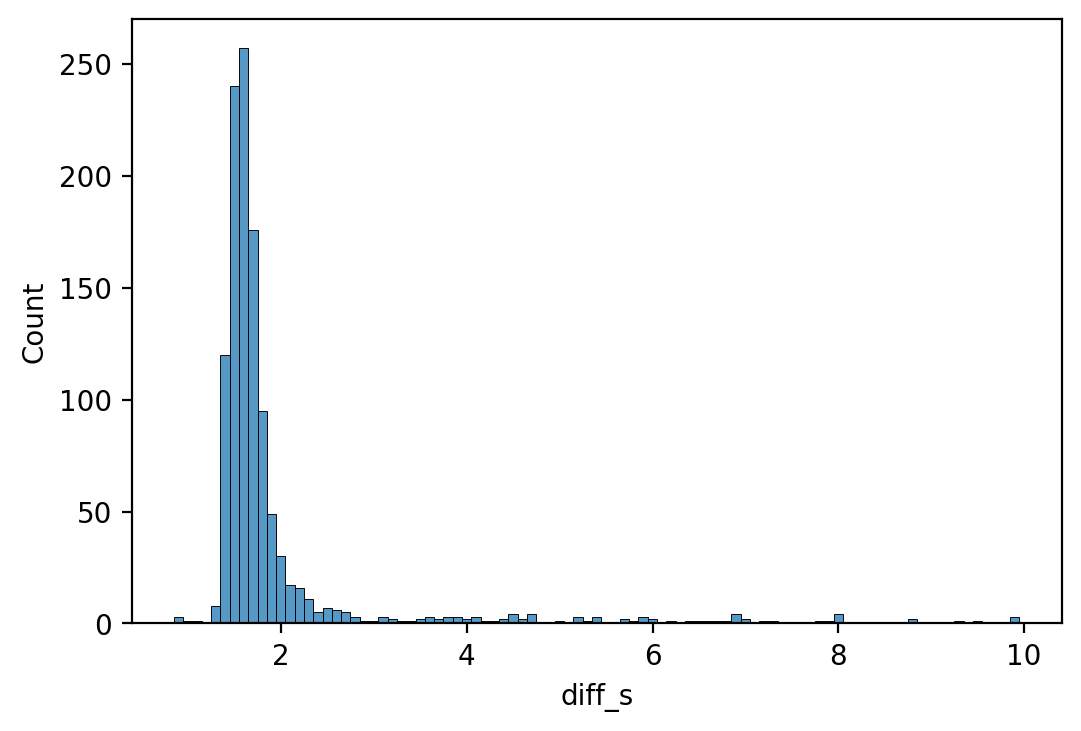

In [32]:
sns.histplot(data=df, x='diff_s', binwidth=0.1)

Going back to why we did this investigation in the first place, we wanted to determine the parameters used for the decision process (e.g., timeout between two wheel runs, speed, distance)*. From the data, we conclude the following:

We set the timeout between wheel runs to 5 seconds. I.e., if the hamster steps back on the wheel within 5 seconds, any decision timer continues to run. If the hamster steps off for more than 5 seconds, the decision timer ends and locks a decision in. Again, this approach cannot distinguish between "slow running" and "stepping off the wheel and back on".

# Determine the speed of the hamster and distance traveled

Let's for a typical night determine how fast and how far the hamster is running.